# I: Create a dependency(?) matrix across all participants
## P(Sent i and sent j)/(P(Senti) * P(Sentj))

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import xlrd
import pickle
import seaborn as sb

%autosave 5

#import Alex-scored free recall sheets for story 43
xls43 = pd.ExcelFile('/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx')

#get sheet names
xls = xlrd.open_workbook(r'/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx', on_demand=True)
sheet_names = xls.sheet_names()

#import story stats in order to get story lengths
pickle_in = open("story_stats.pickle","rb")
story_stats = pickle.load(pickle_in)

#import story boundaries to get putative event boundaries
pickle_in = open("story_boundaries.pickle","rb")
story_boundaries = pickle.load(pickle_in)

#import subj_schemas matrix so that for each story for each subject you can know if they are
#social or location primed
pickle_in = open("subj_schemas.pickle","rb")
subj_schemas = pickle.load(pickle_in)

Autosaving every 5 seconds


# Part 1: Create a dependency(?) matrix between the sentences of the story based on their mentions in the free recall across all participants
### Step 1:Put the scored sheet of each participant in a new entry of a dictionary
### Step 2:Make a participant x story sentences matrix with '1' values for sentences that that participant mentioned in their free recall
### Step 3:Make the dependency matrix 

In [2]:
##Step 1:put the scored sheet of each participant in a new entry of a dictionary

rs_dict = {}

for name in sheet_names:
    rs_dict[name] = pd.read_excel(xls43, name)

In [3]:
##Step 2:make a participant x story sentences matrix with '1' values for sentences that that 
#participant mentioned in their free recall

#find the number of sentences in story 43
n_sent = story_stats['43'][3]
subj_sent_m = np.zeros((len(sheet_names), n_sent))
count = 0

for name in sheet_names:
    for i in range(n_sent):
        val = np.sum(rs_dict[name][i+1])
        if val > 0:
            val = 1
        subj_sent_m[count, i] = val
    count += 1

In [4]:
sheet_names

['091619_p1',
 '091819_p2',
 '092319_p1',
 '092319_p2',
 '092319_p3',
 '092419_p1',
 '100419_p1',
 '100719_p2',
 '101019_p1',
 '111319_p1',
 '111919_p1',
 '111919_p2',
 '112019_p1']

In [5]:
##Step 3: Make the dependency matrix, which is a sentence by sentence matrix
#where the probability of sentence x and sentence y being recalled together is divided by
#the probability of just sentence x being recalled times the probability of just sentence y
#being recalled.
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]
##Part 4.1: Import the putative event boundaries for story 43

/Users/alexreblando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in double_scalars



0.07692307692307693 0.07692307692307693
0.07692307692307693
13.0


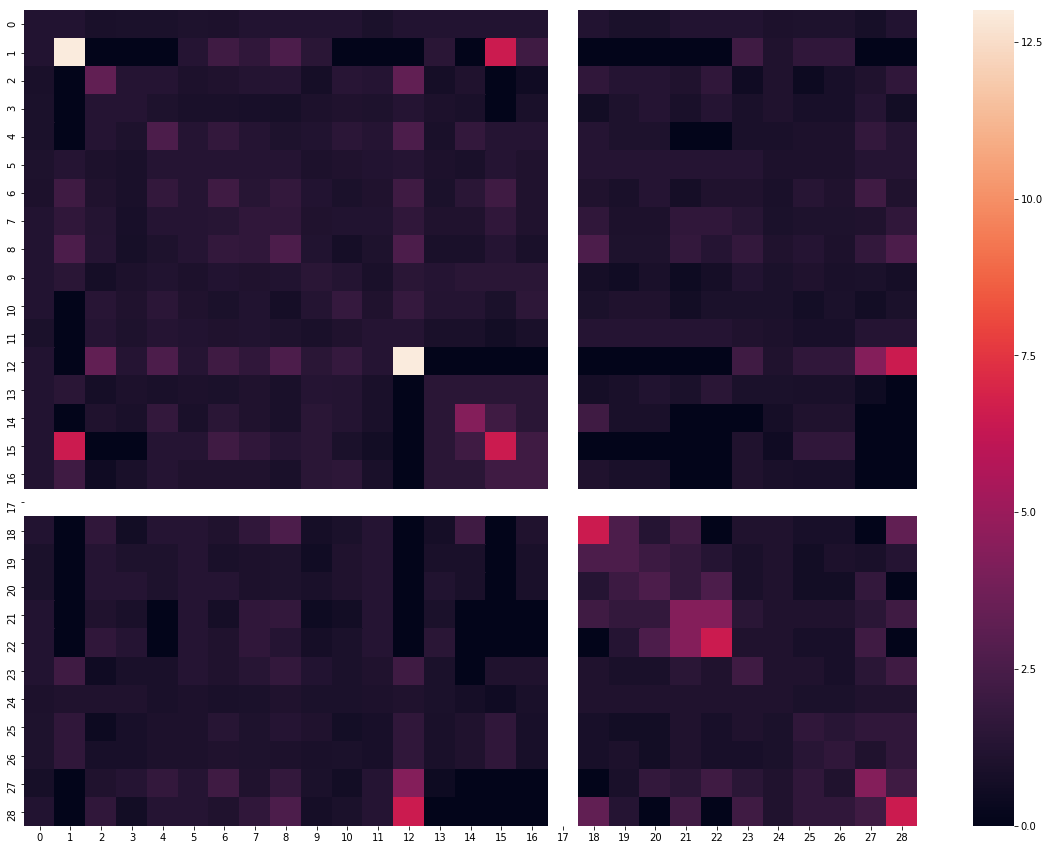

In [7]:
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))

#make the empty sentence x sentence matrix
norm_dep_matrix = np.zeros((n_sent,n_sent))

subj, sents = subj_sent_m.shape

for i in range(sents):
    for j in range(sents):
        first_prob = np.sum(subj_sent_m[:, i])/subj
        second_prob = np.sum(subj_sent_m[:, j])/subj
        ##test
        if i == 1 and j == 1:
            print(first_prob, second_prob)
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_prob = count/subj
        ##test
        if i == 1 and j == 1:
            print(first_second_prob)
            print(first_second_prob/(first_prob * second_prob))
        norm_dep_matrix[i, j] = first_second_prob/(first_prob * second_prob)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(norm_dep_matrix)
#heatmap = sb.heatmap(dep_matrix, vmin=0, vmax=2)
plt.show()

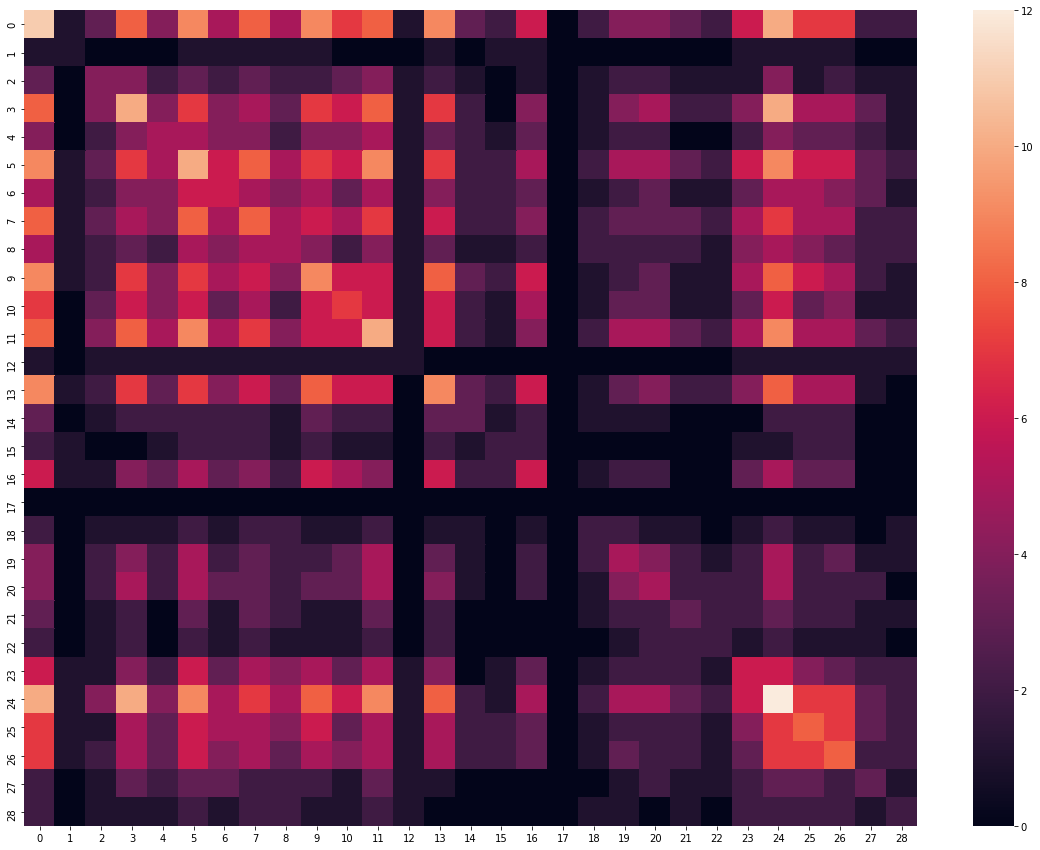

In [8]:
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions

#make the empty sentence x sentence matrix
dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_cooccurrence_sum = count
        dep_matrix[i, j] = first_second_cooccurrence_sum
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(dep_matrix)
plt.show()

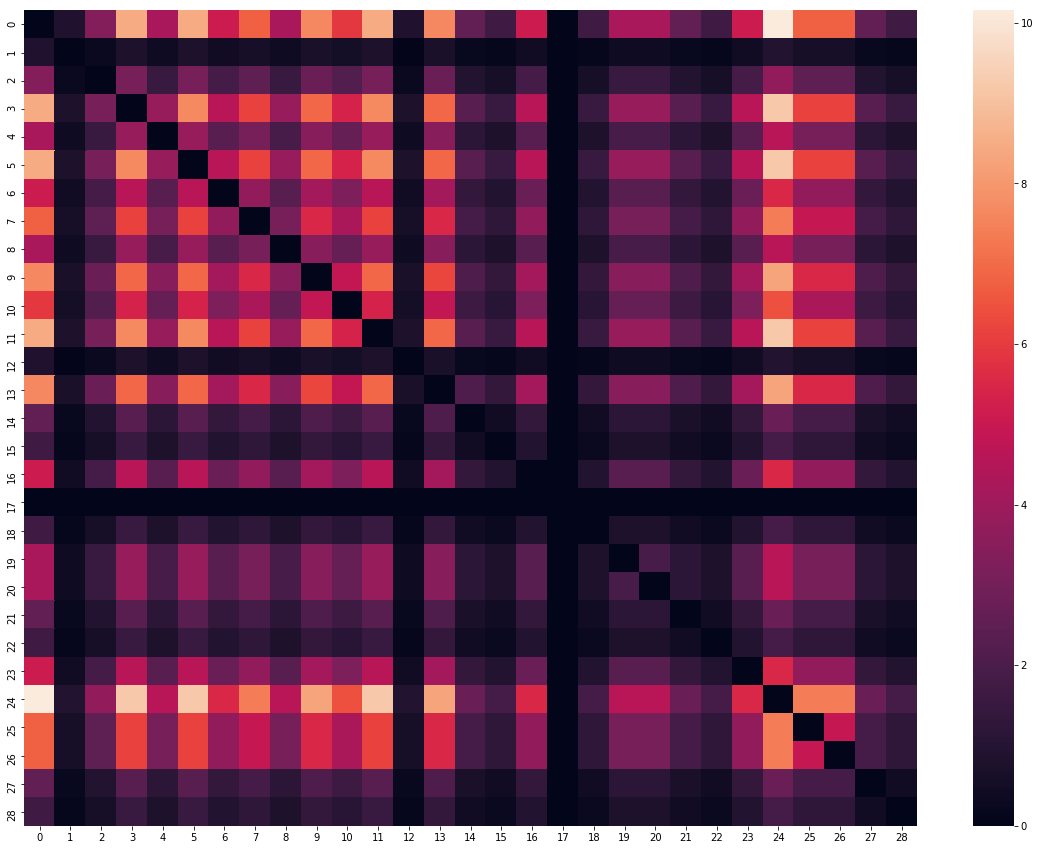

In [9]:
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]

null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        ##why am i dividing by subjects?
        null_dep_matrix[i,j] = subj*dep_matrix[i,i]/subj * dep_matrix[j,j]/subj
null_dep_matrix = null_dep_matrix + null_dep_matrix.T
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(null_dep_matrix)
plt.show()

# II: Social Primed Participant Analysis


In [10]:
#Part 4: SOCIAL PRIMED PARTICIPANTS

#Step 1: make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for social primed participants

#find the number of sentences in story 43
n_sent = story_stats['43'][3]

#the number of social primed participants
n_social = (sum( x == 'Social' for x in subj_schemas['43'].values()))

#make empty participant x story sentences matrix
soc_subj_sent_m = np.zeros((n_social, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas['43'][name] == 'Social':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            soc_subj_sent_m[count, i] = val
        count += 1

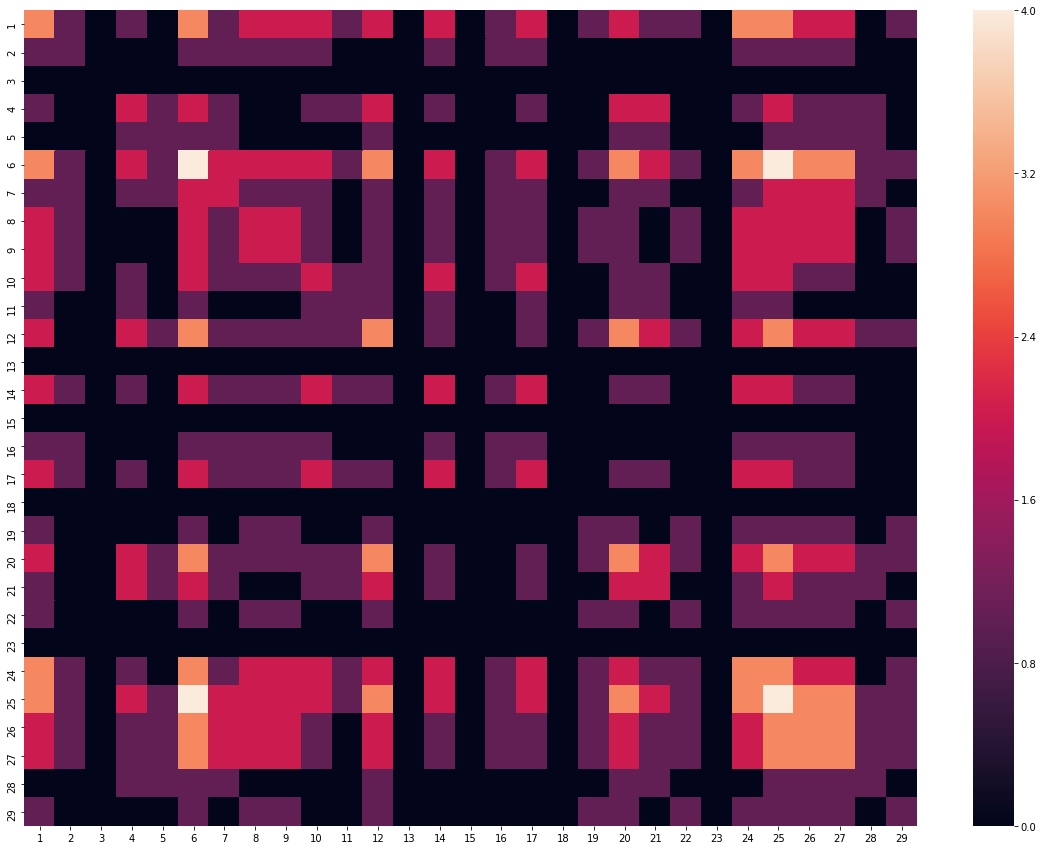

In [11]:
#Part 4.1: Make the co occurrence count of social primed participants

#make the empty sentence x sentence matrix
soc_dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(n_social):
            if soc_subj_sent_m[k, i] == 1:
                if soc_subj_sent_m[k, j] == 1:
                    count += 1
        soc_dep_matrix[i, j] = count

#convert np array to dataframe with correctly labeled sentences        
index = list(range(1, sents+1))
df_soc_dep_matrix = pd.DataFrame(data=soc_dep_matrix, index=index, columns= index)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_soc_dep_matrix)
plt.show()

In [12]:
soc_subj_sent_m

array([[0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.]])

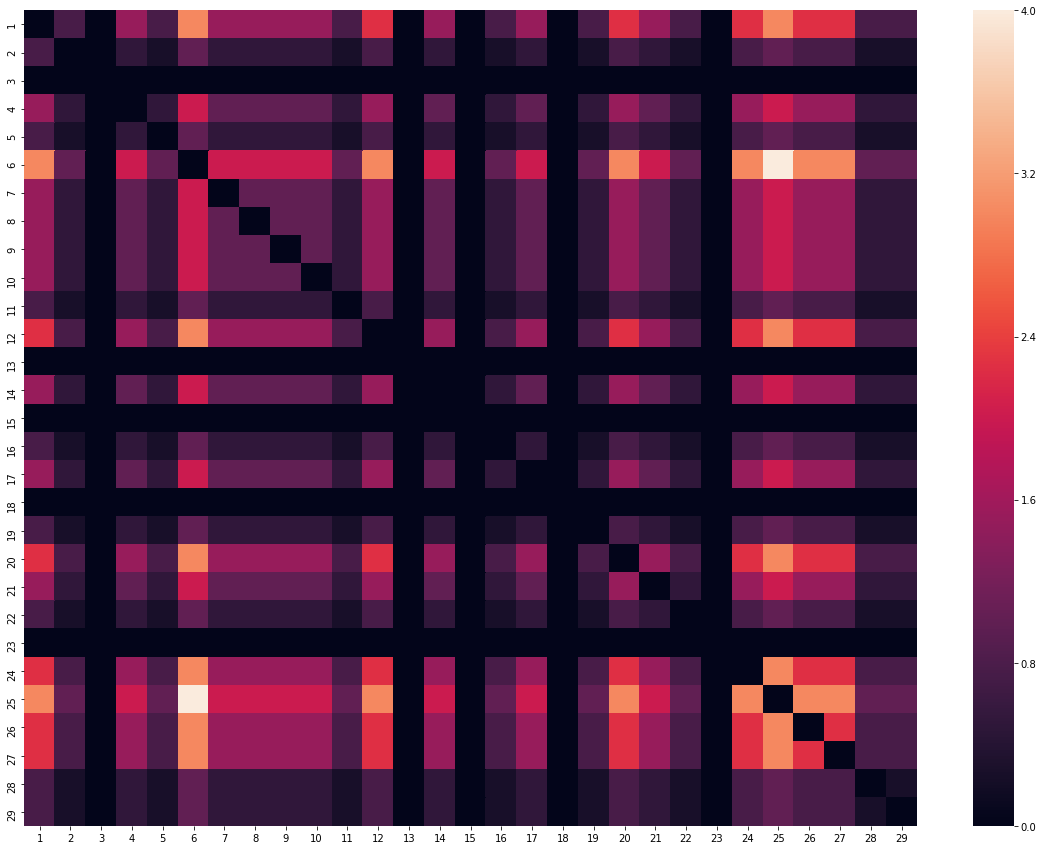

In [13]:
#Part 4.2 Make the null dependency matrix for social primed responses
soc_null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        soc_null_dep_matrix[i,j] = soc_dep_matrix[i,i] * soc_dep_matrix[j,j]/n_social
soc_null_dep_matrix = soc_null_dep_matrix + soc_null_dep_matrix.T

#convert to pd to correctly label axes
df_soc_null_dep_matrix = pd.DataFrame(data=soc_null_dep_matrix, index=index, columns= index)
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_soc_null_dep_matrix)
plt.show()

In [14]:
#4.3: SOCIAL PRIMED PARTICIPANTS PARCED INTO *SOCIAL* EVENTS:
#divide the co occurence matrix and the null dependency matrix into the SOCIAL events

#find the story sentences that mark the boundaries of each social event
SP_soc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    SP_soc_event[i] = np.zeros((1,4))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 1] == 1:
        if count == 1:
            SP_soc_event[count][0,0] = 1
            count = 2
        else:
            SP_soc_event[count-1][0,1] = j
            SP_soc_event[count][0,0] = j+1
            count += 1
        
SP_soc_event[4][0,1] = len(story_boundaries['43']) 

In [15]:
#4.3.2 SOCIAL events Co-occurence sums of actual and null co occurence matrices
#using pd matrices bc the sentences are correctly labeled

for i in range(1,5):
    x, y, z, a = SP_soc_event[i][0]
    soc_sum = 0
    null_soc_sum = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                soc_sum += df_soc_dep_matrix.loc[m,n]
                null_soc_sum += df_soc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    SP_soc_event[i][0,2] = soc_sum/2
    SP_soc_event[i][0,3] = null_soc_sum/2  

In [16]:
df_soc_dep_matrix.to_excel("soc_dep_matrix.xlsx")
df_soc_null_dep_matrix.to_excel("soc_null_dep_matrix.xlsx")

SP_soc_event

{1: array([[1.  , 5.  , 3.  , 4.25]]),
 2: array([[ 6.  , 13.  , 25.  , 26.75]]),
 3: array([[14., 25., 38., 39.]]),
 4: array([[26. , 29. ,  7. ,  5.5]])}

In [17]:
#4.4: SOCIAL PRIMED PARTICIPANTS PARCED INTO *LOCATION* EVENTS:

#divide the co occurence matrix and the null dependency matrix into the LOCATION events

#find the story sentences that mark the boundaries of each LOCATION event
SP_loc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    SP_loc_event[i] = np.zeros((1,4))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 0] == 1:
        if count == 1:
            SP_loc_event[count][0,0] = 1
            count = 2
        else:
            SP_loc_event[count-1][0,1] = j
            SP_loc_event[count][0,0] = j+1
            count += 1
        
SP_loc_event[4][0,1] = len(story_boundaries['43']) 

In [343]:
SP_loc_event

{1: array([[1.  , 3.  , 1.  , 0.75]]),
 2: array([[ 4.  , 11.  , 25.  , 27.25]]),
 3: array([[12.  , 18.  ,  6.  ,  5.75]]),
 4: array([[19., 29., 55., 53.]])}

In [342]:
#4.4.2 LOCATION events: Co-occurence sums of actual and null co occurence matrices
#using pd matrices bc the sentences are correctly labeled

for i in range(1,5):
    x, y, z, a = SP_loc_event[i][0]
    soc_sum = 0
    null_soc_sum = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                soc_sum += df_soc_dep_matrix.loc[m,n]
                null_soc_sum += df_soc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    SP_loc_event[i][0,2] = soc_sum/2
    SP_loc_event[i][0,3] = null_soc_sum/2

In [323]:
SP_soc_event

{1: array([[1.  , 5.  , 3.  , 4.25]]),
 2: array([[ 6.  , 13.  , 25.  , 26.75]]),
 3: array([[14., 25., 38., 39.]]),
 4: array([[26. , 29. ,  7. ,  5.5]])}

In [324]:
SP_loc_event

{1: array([[1.  , 3.  , 1.  , 0.75]]),
 2: array([[ 4.  , 11.  , 25.  , 27.25]]),
 3: array([[12.  , 18.  ,  6.  ,  5.75]]),
 4: array([[19., 29., 55., 53.]])}

# III: Location-primed participants

In [325]:
#Step 1: make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for location primed participants

#find the number of sentences in story 43
n_sent = story_stats['43'][3]

#the number of social primed participants
n_location = (sum( x == 'Location' for x in subj_schemas['43'].values()))

#make empty participant x story sentences matrix
loc_subj_sent_m = np.zeros((n_location, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas['43'][name] == 'Location':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            loc_subj_sent_m[count, i] = val
        count += 1

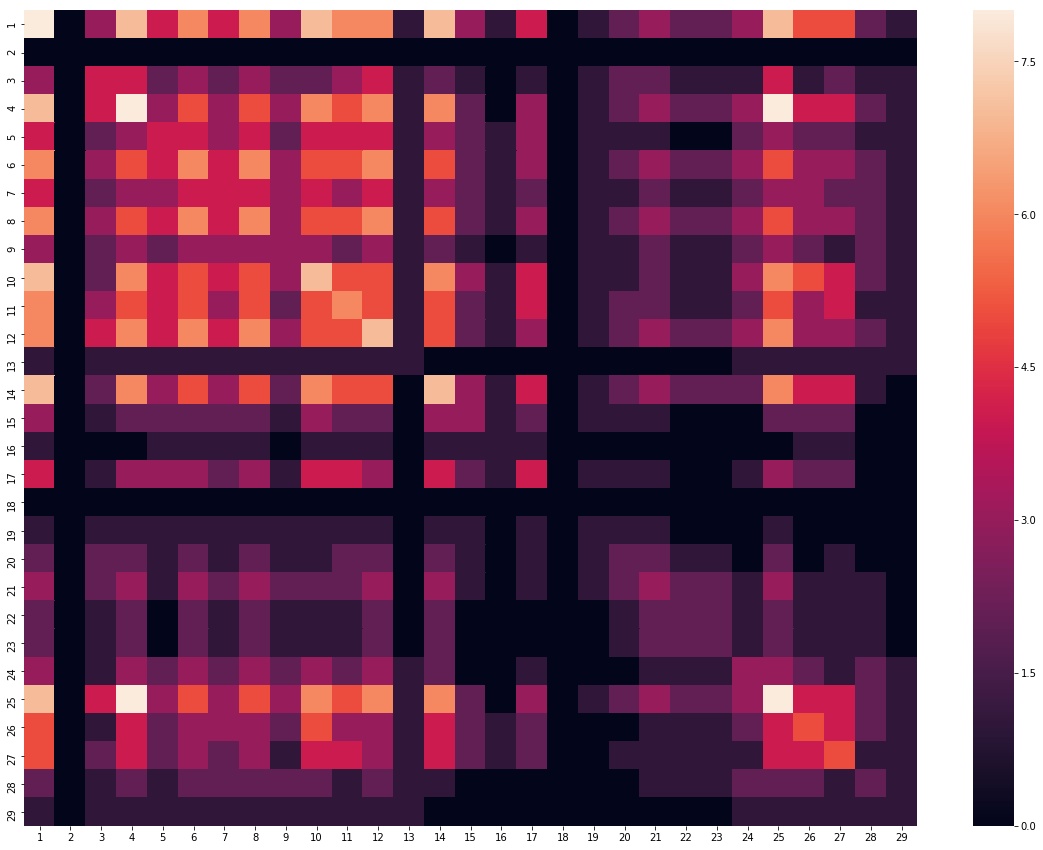

In [326]:
#Part 5.1: Make the co occurrence count of location primed participants

#make the empty sentence x sentence matrix
loc_dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        count = 0
        for k in range(n_location):
            if loc_subj_sent_m[k, i] == 1:
                if loc_subj_sent_m[k, j] == 1:
                    count += 1
        loc_dep_matrix[i, j] = count

#convert np array to dataframe with correctly labeled sentences        
index = list(range(1, sents+1))
df_loc_dep_matrix = pd.DataFrame(data=loc_dep_matrix, index=index, columns= index)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_loc_dep_matrix)
plt.show()

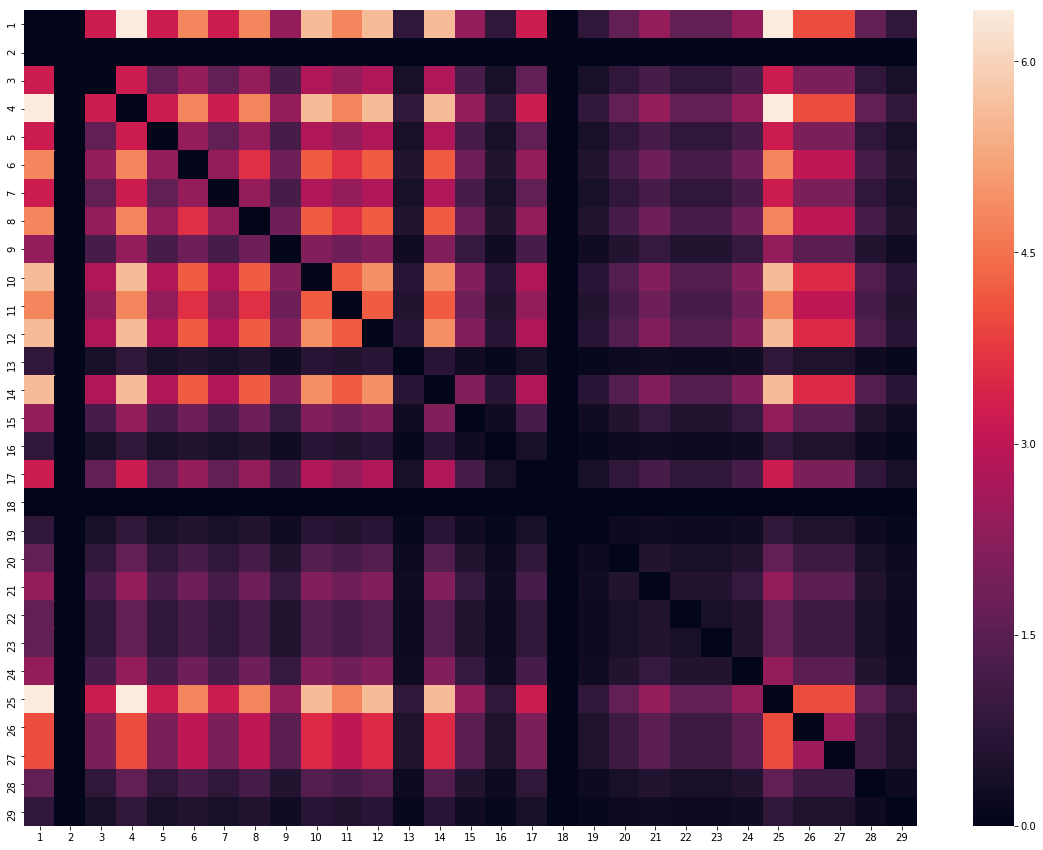

In [327]:
#Part 5.2 Make the null dependency matrix for location primed responses
loc_null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        loc_null_dep_matrix[i,j] = loc_dep_matrix[i,i] * loc_dep_matrix[j,j]/n_location
loc_null_dep_matrix = loc_null_dep_matrix + loc_null_dep_matrix.T

#convert to pd to correctly label axes
df_loc_null_dep_matrix = pd.DataFrame(data=loc_null_dep_matrix, index=index, columns= index)
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(df_loc_null_dep_matrix)
plt.show()

In [329]:
#5.3: LOCATION PRIMED PARTICIPANTS PARCED INTO *SOCIAL* EVENTS:
#divide the co occurence matrix and the null dependency matrix into the SOCIAL events

#find the story sentences that mark the boundaries of each social event
LP_soc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    LP_soc_event[i] = np.zeros((1,4))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 1] == 1:
        if count == 1:
            LP_soc_event[count][0,0] = 1
            count = 2
        else:
            LP_soc_event[count-1][0,1] = j
            LP_soc_event[count][0,0] = j+1
            count += 1
        
LP_soc_event[4][0,1] = len(story_boundaries['43']) 

In [331]:
#5.3.2 SOCIAL events Co-occurence sums of actual and null co occurence matrices
#using pd matrices bc the sentences are correctly labeled

for i in range(1,5):
    x, y, z, a = LP_soc_event[i][0]
    loc_sum = 0
    null_loc_sum = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                loc_sum += df_loc_dep_matrix.loc[m,n]
                null_loc_sum += df_loc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    LP_soc_event[i][0,2] = loc_sum/2
    LP_soc_event[i][0,3] = null_loc_sum/2  

In [333]:
#5.4: LOCATION PRIMED PARTICIPANTS PARCED INTO *LOCATION* EVENTS:

#divide the co occurence matrix and the null dependency matrix into the LOCATION events

#find the story sentences that mark the boundaries of each LOCATION event
LP_loc_event = {}

#make the dictionary of all the events
for i in range(1,5):
    LP_loc_event[i] = np.zeros((1,4))

count = 1
for j in range(len(story_boundaries['43'])):
    if story_boundaries['43'][j, 0] == 1:
        if count == 1:
            LP_loc_event[count][0,0] = 1
            count = 2
        else:
            LP_loc_event[count-1][0,1] = j
            LP_loc_event[count][0,0] = j+1
            count += 1
        
LP_loc_event[4][0,1] = len(story_boundaries['43']) 

In [334]:
#5.4.2 LOCATION events: Co-occurence sums of actual and null co occurence matrices
#using pd matrices bc the sentences are correctly labeled

for i in range(1,5):
    x, y, z, a = LP_loc_event[i][0]
    loc_sum = 0
    null_loc_sum = 0
    for m in range(int(x), int(y + 1)):
        for n in range(int(x), int(y + 1)):
            if m == n:
                continue
            else:
                loc_sum += df_loc_dep_matrix.loc[m,n]
                null_loc_sum += df_loc_null_dep_matrix.loc[m,n]
    #dividing by 2 bc the top and the bottom half of the matrix are the same
    ##ask Chris
    LP_loc_event[i][0,2] = loc_sum/2
    LP_loc_event[i][0,3] = null_loc_sum/2

In [335]:
LP_loc_event

{1: array([[1. , 3. , 3. , 3.2]]),
 2: array([[  4. ,  11. , 111. ,  83.7]]),
 3: array([[12. , 18. , 24. , 20.2]]),
 4: array([[19. , 29. , 65. , 50.3]])}

In [336]:
LP_soc_event

{1: array([[ 1. ,  5. , 23. , 20.8]]),
 2: array([[ 6. , 13. , 96. , 68.4]]),
 3: array([[14. , 25. , 70. , 56.3]]),
 4: array([[26. , 29. , 10. ,  5.7]])}

In [344]:
SP_loc_event

{1: array([[1.  , 3.  , 1.  , 0.75]]),
 2: array([[ 4.  , 11.  , 25.  , 27.25]]),
 3: array([[12.  , 18.  ,  6.  ,  5.75]]),
 4: array([[19., 29., 55., 53.]])}

In [338]:
SP_soc_event

{1: array([[1.  , 5.  , 3.  , 4.25]]),
 2: array([[ 6.  , 13.  , 25.  , 26.75]]),
 3: array([[14., 25., 38., 39.]]),
 4: array([[26. , 29. ,  7. ,  5.5]])}

In [345]:
df_loc_dep_matrix.to_excel("loc_dep_matrix.xlsx")
df_loc_null_dep_matrix.to_excel("loc_null_dep_matrix.xlsx")